# BERT Overview and Training Methodology

BERT's masked pretraining, often referred to as the cloze procedure, is a pivotal aspect of its training methodology. In this phase, a random subset of words in each training instance is replaced with a special [MASK] token. The model is then tasked with predicting the original words that were masked out, turning the training into a masked language model (MLM) objective. This approach is instrumental in training a bidirectional understanding of context, as the model must consider both preceding and succeeding words to accurately predict the masked tokens. Additionally, 15% of the words are randomly chosen for masking, and some are kept unchanged to avoid the model overfitting to the [MASK] token. This strategy ensures that the model learns a robust contextual representation of words, capturing intricate semantic relationships within sentences.

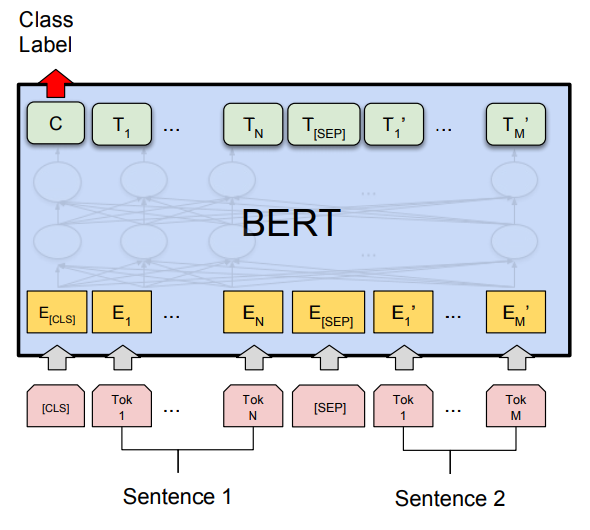

BERT incorporates several ingenious tricks to enhance its training efficiency. One such technique is the use of segment embeddings, where each token is assigned a segment ID to distinguish between sentences in the input. This allows the model to understand the relationships between tokens in different segments, reinforcing its grasp of sentence-level context. Another key trick involves the use of a positional embedding to convey the order of words in a sentence, as BERT doesn't inherently account for word order. These techniques contribute to the creation of rich, context-aware representations during masked pretraining.

During the fine-tuning phase, the [MASK] tokens play a crucial role in adapting BERT to specific tasks. In the task-specific datasets, a small fraction of the tokens is masked, and the model is fine-tuned to predict these masked tokens, similar to the pretraining phase. However, in fine-tuning, only a fraction of the masked tokens is replaced with the [MASK] token, while the rest are replaced with the actual words. This approach prevents the model from solely relying on the [MASK] token during fine-tuning, ensuring that it retains a nuanced understanding of the task-specific data.

In summary, BERT's training methodology involves the cloze procedure during masked pretraining, where [MASK] tokens are used for predicting masked words bidirectionally. Ingenious tricks like segment embeddings and positional embeddings enhance the model's contextual understanding. During fine-tuning, the [MASK] tokens continue to be crucial, but with modifications to prevent over-reliance on them. These strategies collectively contribute to BERT's remarkable ability to capture intricate contextual relationships in natural language, making it a pioneering model in the realm of natural language processing.

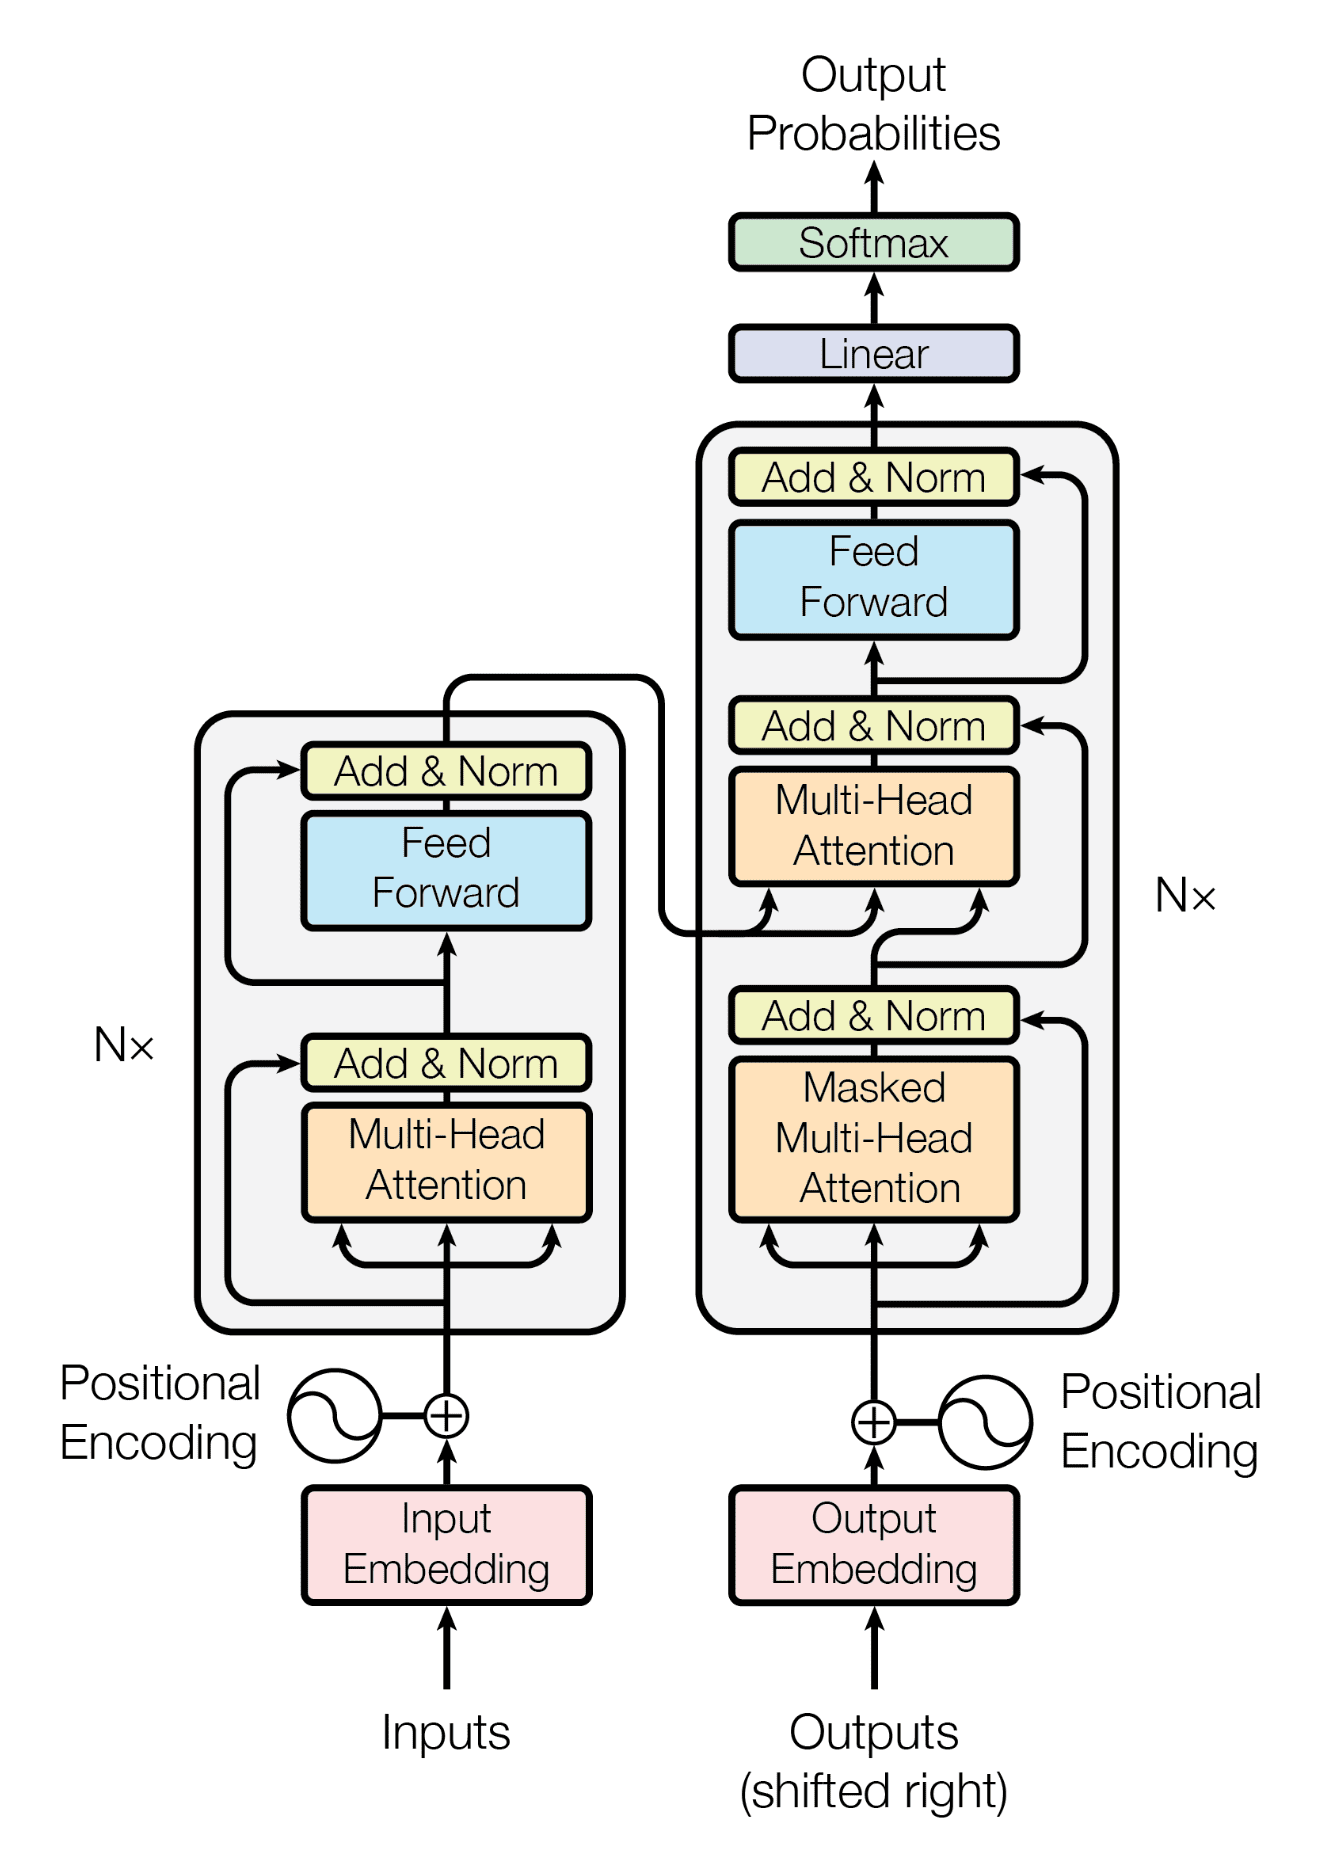

References:

[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

[Mastering BERT Model: Building it from Scratch with Pytorch](https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891)

In [1]:
import math
import random
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer

/home/saul/.pyenv/versions/3.11.8/envs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. BERT Architecture

## 1.1. Input Embeddings

In [2]:
class InputEmbedding(nn.Module):
    def __init__(self, embed_dim: int, vocab_size: int):
        """
        Initialize the InputEmbedding module.

        Args:
            embed_dim (int): The dimensionality of the input embedding.
            vocab_size (int): The size of the vocabulary.

        """
        super().__init__()
        # Store the dimensionality and vocabulary size
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size

        # Create an embedding layer that maps the vocabulary to a embed_dim-dimensional space
        # The embedding layer should have shape (vocab_size, embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
    
    def forward(self, x):
        """
        Perform the forward pass of the InputEmbedding module.

        Args:
            x (tensor): The input tensor.

        Returns:
            tensor: The embedded input tensor after scaling it by the square root of the dimensionality.

        """
        # Embed the input tensor using the embedding layer
        # Shape: (batch_size, seq_len) -> (batch_size, seq_len, embed_dim)
        embedded_input = self.embedding(x)
        # Scale the embedded input tensor by the square root of the dimensionality
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        scaled_embedded_input = embedded_input * torch.sqrt(torch.tensor(self.embed_dim))
        return scaled_embedded_input

## 1.2. Positional Encodings

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim: int = 512, max_seq_len: int = 100, dropout: float = 0.1,):
        """Initialize the PositionalEncoding module."""
        super().__init__()
        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len
        self.dropout = nn.Dropout(dropout)
        # Precompute the positional encoding matrix
        self.positional_encoding = self._precompute_positional_encoding(max_seq_len, embed_dim)

    def _precompute_positional_encoding(self, max_seq_len, embed_dim):
        """Precompute the positional encoding matrix."""
        with torch.no_grad():
            # Create a positional encoding matrix of shape (max_seq_len, embed_dim)
            positional_encoding = torch.zeros(max_seq_len, embed_dim)
            # Create a tensor 'pos' with values [0, 1, 2, ..., max_seq_len - 1] (max_seq_len, 1)
            position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
            # Compute the positional encoding matrix
            division_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
            positional_encoding[:, 0::2] = torch.sin(position * division_term)
            positional_encoding[:, 1::2] = torch.cos(position * division_term)
            # Shape (max_seq_len, embed_dim) -> (1, max_seq_len, embed_dim)
            positional_encoding = positional_encoding.unsqueeze(0)

        return positional_encoding

    def forward(self, x):
        """Perform the forward pass of the PositionalEncoding module."""
        # Add the positional encoding matrix to the input tensor
        x = x + self.positional_encoding[:, : x.size(1)].to(x.device)
        # Apply dropout to the input tensor
        x = self.dropout(x)
        return x

## 1.3. Layer Normalization

In [4]:
class LayerNormalization(nn.Module):
    def __init__(self, embed_dim: int, eps: float = 1e-6):
        """Initialize the LayerNormalization module."""
        super().__init__()
        self.eps = eps
        self.gain = nn.Parameter(torch.Tensor(embed_dim).uniform_())
        self.bias = nn.Parameter(torch.Tensor(embed_dim).normal_())

    def forward(self, x):
        """Perform the forward pass of the LayerNormalization module."""
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return (x - mean) / (std + self.eps) * self.gain + self.bias

## 1.4. Feed-Forward Block

In [5]:
class FeedForwardBlock(nn.Module):
    def __init__(self, embed_dim: int, intermediate_size: int, dropout: float = 0.1):
        """Initialize the FeedForwardBlock module.
        embed_dim is the hidden size of the transformer model functions as input and output size of the FeedForwardBlock
        intermediate_size is the hidden size of the intermediate layer in the FeedForwardBlock
        dropout is the dropout probability
        """
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, intermediate_size)
        self.fc2 = nn.Linear(intermediate_size, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """Perform the forward pass of the FeedForwardBlock module."""
        # (Batch, Seq_len, embed_dim) -> (Batch, Seq_len, intermediate_size) -> (Batch, Seq_len, embed_dim)
        x_intermediate = self.dropout(F.relu(self.fc1(x)))
        x_output = self.fc2(x_intermediate)
        return x_output

## 1.5. Multi-Head Self-Attention

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int = 512, num_heads: int = 8, attn_dropout: float = 0.1, ff_dropout: float = 0.1, max_len: int = 512):
        super().__init__()
        self.num_heads = num_heads
        assert embed_dim % self.num_heads == 0, "invalid heads and embedding dimension configuration"
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.query = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj_dropout = nn.Dropout(ff_dropout)
    
    def forward(self, q:torch.Tensor, k:torch.Tensor, v:torch.Tensor, mask=None,):
        batch_size, seq_len, _ = q.size()
        q = self.query(q).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        k = self.key(k).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        v = self.value(v).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        attention = torch.einsum('bhid,bhjd->bhij', q, k) / math.sqrt(q.size(-1))
        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-inf"))
        attention = self.attn_dropout(F.softmax(attention, dim=-1))
        
        y = torch.einsum('bhij,bhjd->bhid', attention, v)
        y = y.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        return self.proj_dropout(self.proj(y))

## 1.6. Residual Connection

In [7]:
class ResidualConnection(nn.Module):
    def __init__(self, embed_dim, dropout: float = 0.1):
        """Initialize the ResidualConnection module."""
        super().__init__()
        self.layer_norm = LayerNormalization(embed_dim=embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """Perform the forward pass of the ResidualConnection module."""
        sublayer_output = sublayer(x)
        normalized_x = self.layer_norm(x)
        residual_output = normalized_x + sublayer_output
        return self.dropout(residual_output)

## 1.7. Projection Heads

In [8]:
class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, embed_dim, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(embed_dim, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

In [9]:
class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, embed_dim):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = torch.nn.Linear(embed_dim, 1)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))

In [10]:
class ProjectionHead(nn.Module):
    def __init__(self, embed_dim: int, vocab_size: int):
        """Initialize the ProjectionHead module."""
        super().__init__()
        self.masked_lm = MaskedLanguageModel(embed_dim, vocab_size)
        self.next_sentence = NextSentencePrediction(embed_dim)
    
    def forward(self, x):
        """Perform the forward pass of the ProjectionHead module."""
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, vocab_size)
        return self.masked_lm(x), self.next_sentence(x)

## 1.8. Encoder Block

In [11]:
class EncoderBlock(nn.Module):
    def __init__(
        self, 
        embed_dim: int = 512, 
        num_heads: int = 8, 
        ff_dim: int = 2048, 
        attn_dropout: float = 0.1, 
        ff_dropout: float = 0.1, 
        max_len: int = 512,
    ):
        super().__init__()
        # Initialize multi-head self-attention mechanism
        self.MultiHeadAttention = MultiHeadAttention(
            embed_dim=embed_dim, 
            num_heads=num_heads, 
            attn_dropout=attn_dropout, 
            ff_dropout=ff_dropout,
            max_len=max_len,
            )
        # Initialize feed-forward block
        self.feed_forward = FeedForwardBlock(
            embed_dim=embed_dim, 
            intermediate_size=ff_dim, 
            dropout=ff_dropout,
            )
        # Initialize residual connections
        self.residual_connection1 = ResidualConnection(embed_dim=embed_dim, dropout=ff_dropout)
        self.residual_connection2 = ResidualConnection(embed_dim=embed_dim, dropout=ff_dropout)

    def forward(self, x, attention_mask=None):
        # Apply self-attention mechanism with residual connection
        x_with_attention = self.residual_connection1(x, lambda x: self.MultiHeadAttention(x, x, x, mask=attention_mask))
        # Apply feed-forward block with residual connection
        x_with_ff = self.residual_connection2(x_with_attention, self.feed_forward)
        return x_with_ff

## 1.9. Full BERT Architecture

In [12]:
class Bert(nn.Module):
    def __init__(
        self,
        embed_dim:int = 512,
        vocab_size:int = 10000,
        num_segments:int = 3,
        max_seq_len:int = 100,
        attn_dropout:float = 0.1,
        ff_dropout:float = 0.1,
        n_blocks:int = 6,
        num_heads:int = 8,
        ff_dim:int = 2048,
    ):
        """Initialize the Encoder module."""
        super().__init__()
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        # (768, 30_000) Uses Wordpiece Embedding
        self.embedding = InputEmbedding(embed_dim=embed_dim, vocab_size=vocab_size)
        # (768 30_000) Positional Embedding max_length is the context window size, model won't be able to see beyond this
        self.positional_encoding = PositionalEncoding(
            embed_dim=embed_dim, 
            max_seq_len=max_seq_len, 
            dropout=ff_dropout,
        )
        # distinguish between 3 segments: segment A, segment B, and padding
        # the forward method ends up as (batch_size, seq_len, embed_dim)
        self.segment_embed = nn.Embedding(num_segments, embed_dim)
        self.blocks = nn.ModuleList([
            EncoderBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                ff_dim=ff_dim,
                attn_dropout=attn_dropout,
                ff_dropout=ff_dropout,
            ) for _ in range(n_blocks)
        ])
        self.projection_head = ProjectionHead(embed_dim=embed_dim, vocab_size=vocab_size)


    def forward(self, input_ids: torch.Tensor, src_mask: torch.Tensor = None):
        # (batch_size, seq_len) -> (batch_size, seq_len, embed_dim)
        x = self.embedding(input_ids)
        # (batch_size, seq_len, embed_dim) + (batch_size, seq_len, embed_dim)
        x = x + self.segment_embed(src_mask)
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        x = self.positional_encoding(x)
        # Apply the blocks
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        for block in self.blocks:
            x = block(x)
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, vocab_size), (batch_size, 2)
        x = self.projection_head(x)
        return x

# BERT Training Methodology

## 1. Model Initialization

In [13]:
embed_dim = 512
vocab_size = 10000
max_seq_len = 100
n_blocks = 1
num_heads = 8
ff_dim = 2048

# Create an instance of the Encoder class
sample_model = Bert(
    embed_dim=embed_dim, 
    vocab_size=vocab_size, 
    max_seq_len=max_seq_len,
    n_blocks=n_blocks, 
    num_heads=num_heads, 
    ff_dim=ff_dim,
)

# Define your input tensor
input_ids = torch.tensor([[1, 2, 3, 4, 0], [1, 2, 3, 0, 0]])  # Input token IDs
segment_ids = torch.tensor([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])  # Segment IDs

# Pass the input tensor through the Encoder
output = sample_model(input_ids, src_mask=segment_ids)
print(f"Masked Lanaguage Output: {output[0].shape}")
print(f"Next Sentence Output: {output[1].shape}")

Masked Lanaguage Output: torch.Size([2, 5, 10000])
Next Sentence Output: torch.Size([2, 1])


## 2. Data Preparation

In [14]:
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=64):

        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
         # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']] # label is 1/0 for each token
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len
        segment_ids = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        input_ids = (t1 + t2)[:self.seq_len]
        masked_lm_labels = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(input_ids))]
        input_ids.extend(padding), masked_lm_labels.extend(padding), segment_ids.extend(padding)

        # Converting to tensor
        input_ids = torch.tensor(input_ids).long()
        segment_ids = torch.tensor(segment_ids).long()
        masked_lm_labels = torch.tensor(masked_lm_labels).long()
        is_next_label = torch.tensor(is_next_label).long()

        return input_ids, segment_ids, masked_lm_labels, is_next_label

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            if prob < 0.15:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(token_id)

                output_label.append(token_id)

            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]

In [15]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

sample_data = [
    ["Mary had a little lamb", "Its fleece was white as snow",],
    ["Everywhere that Mary went", "The lamb was sure to go",],
    ["Well, I thought we'd start with pronunciation, if that's okay with you.", 'Not the hacking and gagging and spitting part. Please.'], 
    ['Not the hacking and gagging and spitting part. Please.', "Okay... then how 'bout we try out some French cuisine. Saturday? Night?"], 
    ["You're asking me out. That's so cute. What's your name again?", 'Forget it.'], 
    ["No, no, it's my fault -- we didn't have a proper introduction ---", 'Cameron.']
]

In [16]:
max_seq_len = 100
vocab_size = tokenizer.vocab_size # 30522
batch_size = 2

In [17]:
train_dataset = BERTDataset(
   sample_data,
   seq_len=max_seq_len,
   tokenizer=tokenizer,
   )

train_loader = DataLoader(
   train_dataset,
   batch_size=batch_size, 
   shuffle=True, 
   )

In [18]:
# Print the first sample from the dataset to understand the data format
print(sample_data[0]) # ['Mary had a little lamb', 'Its fleece was white as snow']

# Lets look at the input_ids.
    # Notice we have added token 101 ([CLS]) at the start and 102 ([SEP]) at the end
    # Token 0 is the padding token to make the sequence length equal to max_seq_len
    # Token 103 is the mask token, these values will pop up in the masked_lm_labels
# The segment_ids are used to distinguish between the two sentences
    # Notice that the segment_ids are 1 for the first sentence and 2 for the second sentence
    # Specifically the 2s start after the [SEP] token
    # The segment_ids are also padded with 0s
# The masked_lm_labels are used to train the Masked Language Model
    # The masked_lm_labels are 0 for the tokens that are not masked
    # The masked_lm_labels are the original token ids for the masked tokens
# The is_next_label is used to train the Next Sentence Prediction model
    # The is_next_label is 1 if the second sentence follows the first sentence
    # The is_next_label is 0 if the second sentence does not follow the first sentence
print(train_dataset[0]) # (input_ids, segment_ids, masked_lm_labels, is_next_label)

['Mary had a little lamb', 'Its fleece was white as snow']
(tensor([  101,  2984,  2018,  1037, 10499, 12559,   102,  2049, 10574,  3401,
         2001,   103,  2004,  4586,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## 3. Training Loop

In [19]:
embed_dim = 768
n_blocks = 2
num_heads = 12
ff_dim = 2048
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #"cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 5e-5
num_epochs = 5

In [20]:
# Create an instance of the Encoder class
model = Bert(
    embed_dim=embed_dim, 
    vocab_size=vocab_size, 
    max_seq_len=max_seq_len,
    n_blocks=n_blocks, 
    num_heads=num_heads, 
    ff_dim=ff_dim,
)

In [21]:
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion1 = nn.NLLLoss(ignore_index=0)
criterion2 = nn.BCEWithLogitsLoss()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,)
num_epochs = 2

In [22]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    epoch_mask_loss = 0.0
    epoch_ns_loss = 0.0

    for batch in train_loader:
        # Step 1: Move batch to device
        input_ids, segment_ids, masked_lm_labels, is_next = batch
        input_ids = input_ids.to(device)
        segment_ids = segment_ids.to(device)
        masked_lm_labels = masked_lm_labels.view(-1).to(device)
        is_next = is_next.unsqueeze(1).float().to(device)

        # Step 2: Forward pass (batch_size, seq_len, embed_dim)
        output = model(input_ids, segment_ids)
        output_lm = output[0].view(-1, vocab_size)
        output_ns = output[1]

        # Step 3: Loss for masked LM
        loss_mask = criterion1(output_lm, masked_lm_labels)

        # Step 4: Loss for next sentence prediction
        next_sentence_loss = criterion2(output_ns, is_next)

        # Step 5: Total loss
        loss = loss_mask + next_sentence_loss

        # Step 6: Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step 7: Print loss
        epoch_mask_loss += loss_mask.item()
        epoch_ns_loss += next_sentence_loss.item()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss/len(train_loader)}')
    print(f'Epoch {epoch+1}/{num_epochs}, Mask Loss: {epoch_mask_loss/len(train_loader)}')
    print(f'Epoch {epoch+1}/{num_epochs}, Next Sentence Loss: {epoch_ns_loss/len(train_loader)}')

Epoch 1/2, Total Loss: 11.3587646484375
Epoch 1/2, Mask Loss: 10.665617307027182
Epoch 1/2, Next Sentence Loss: 0.6931471824645996
Epoch 2/2, Total Loss: 11.064749399820963
Epoch 2/2, Mask Loss: 10.371601740519205
Epoch 2/2, Next Sentence Loss: 0.6931471824645996


# 4. BERT Inference

In [23]:
batch = next(iter(train_loader))
input_ids, segment_ids, masked_lm_labels, is_next = batch
input_ids = input_ids.to(device)
segment_ids = segment_ids.to(device)
model.eval()
output = model(input_ids, segment_ids)
print(f"Masked Language Model Output: {output[0].shape}")
print(f"Next Sentence Prediction Output: {output[1].shape}")

Masked Language Model Output: torch.Size([2, 100, 30522])
Next Sentence Prediction Output: torch.Size([2, 1])


# 5. How to Use BERT for Downstream Tasks (Like Text Classification)

In [38]:
class NewProjectionHead(nn.Module):
    def __init__(self, embed_dim, n_labels):
        super().__init__()
        self.fc = nn.Linear(embed_dim, n_labels)

    def forward(self, x):
        # get the representation of the first token [CLS] token for classificaiton
        x = x[:, 0]
        # Apply a linear layer
        x = self.fc(x)
        return x

In [39]:
new_model = model
new_model.projection_head = NewProjectionHead(embed_dim, 2)

In [40]:
new_model.eval()
new_model.to(device)
output = new_model(input_ids, segment_ids)

print(f"Input Shape: {input_ids.shape}") # (batch_size, seq_len) (2, 100)
print(f"Mask Label Shape: {masked_lm_labels.shape}") # (batch_size, seq_len) (2, 100)
print(f"Output Shape: {output.shape}") # (batch_size, seq_len, 2) (2, 100, 2)

Input Shape: torch.Size([2, 100])
Mask Label Shape: torch.Size([2, 100])
Output Shape: torch.Size([2, 2])
